In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import matplotlib
import scipy

matplotlib.rcParams['figure.figsize'] = [12, 5]

In [100]:
with open("../export/image_catalogue.json") as ic_file:
    image_catalog = json.load(ic_file)
    types_map = [v["type"] for k, v in sorted(image_catalog.items()) if k.isnumeric()]

In [101]:
rating_files = glob.glob("../export/*_rating.csv")
rating_files.sort()
rating_files[-1]

'../export/20221224-151701_rating.csv'

In [102]:
questions = ["Fictional/Real", "Human-made/Human-like", "Eerie/Ordinary", "Unsettling/Plain", "Creepy/Dull",
             "Hair-raising/Unemotional", "Hostile/Friendly", "Grumpy/Cheerful", "Cold-hearted/Warm-hearted"]

In [103]:
ratings = pd.read_csv(rating_files[-1], index_col=["index"],
                      names=["index", "timestamp", "img"] + questions + ["uid"])
ratings = ratings.reset_index().drop(["index"], axis=1)
ratings["type"] = [types_map[img - 1] for img in ratings["img"]]

ratings["Fictional/Real"] -= 4
ratings["Human-made/Human-like"] -= 4
ratings["Eerie/Ordinary"] = 7 - ratings["Eerie/Ordinary"]
ratings["Unsettling/Plain"] = 7 - ratings["Unsettling/Plain"]
ratings["Creepy/Dull"] = 7 - ratings["Creepy/Dull"]
ratings["Hair-raising/Unemotional"] = 7 - ratings["Hair-raising/Unemotional"]
ratings["Hostile/Friendly"] -= 4
ratings["Grumpy/Cheerful"] -= 4
ratings["Cold-hearted/Warm-hearted"] -= 4

# Image Distribution

<AxesSubplot: >

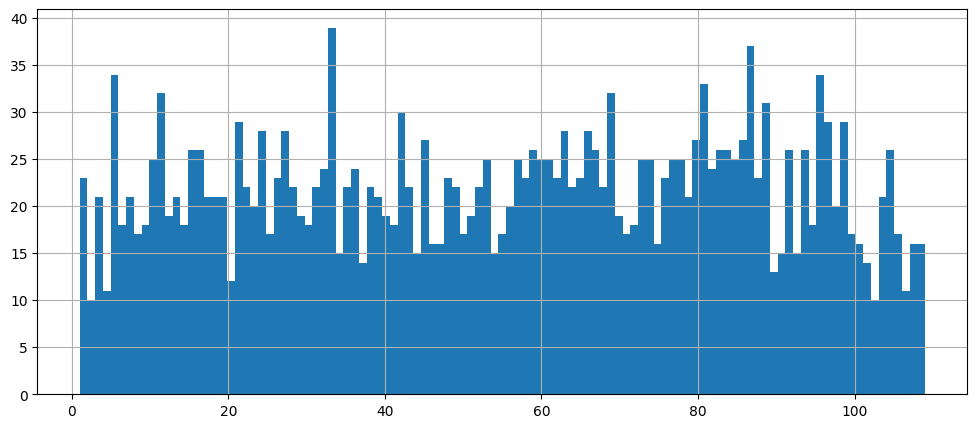

In [104]:
ratings["img"].hist(bins=max(ratings["img"]))

# Ratings Distribution

In [105]:
def analyse_columns(column, ratings):
    fig, axes = plt.subplots(1, 4)
    fig.suptitle(column, fontsize=16)
    ratings[column].hist(bins=max(ratings[column]), ax=axes[0])
    axes[0].set_title('all')
    ratings[ratings["type"] == "human"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]), ax=axes[1])
    axes[1].set_title('human')
    ratings[ratings["type"] == "semi-realistic"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                              ax=axes[2])
    axes[2].set_title('semi-realistic')
    ratings[ratings["type"] == "animated_grey"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                             ax=axes[3])
    axes[3].set_title('animated_grey')
    plt.show()
    f, f_p = scipy.stats.f_oneway(ratings[ratings["type"] == "human"][column],
                                  ratings[ratings["type"] == "semi-realistic"][column],
                                  ratings[ratings["type"] == "animated_grey"][column])
    u, u_p = scipy.stats.mannwhitneyu(ratings[ratings["type"] == "semi-realistic"][column],
                                      ratings[column])

    print(
        "All: {:.2f}, Human: {:.2f}, Semi Realistic: {:.2f}, Cartoon: {:.2f}, Anova p-value: {:.2f}, Mann–Whitney p-value: {:.2f} (semi vs all)".format(
            ratings[column].mean(),
            ratings[ratings["type"] == "human"][column].mean(),
            ratings[ratings["type"] == "semi-realistic"][column].mean(),
            ratings[ratings["type"] == "animated_grey"][column].mean(), f_p, u_p))

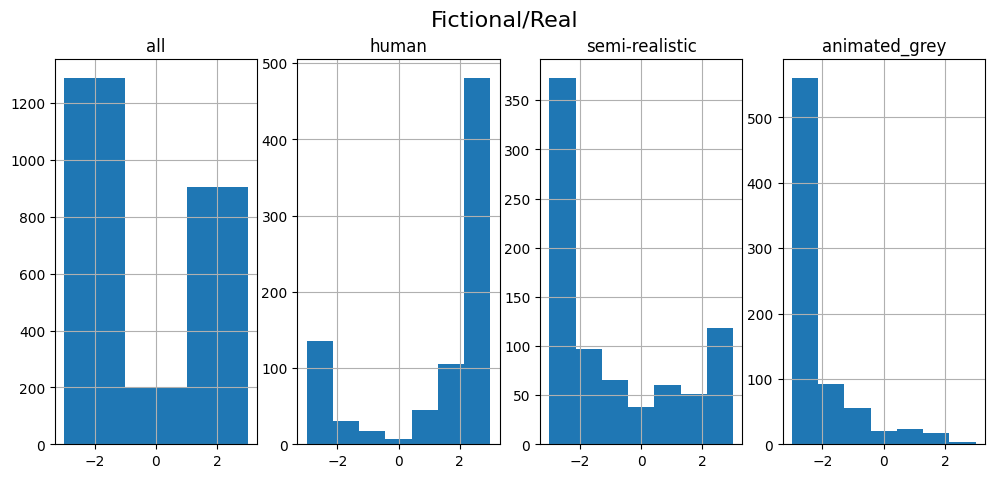

All: -0.63, Human: 1.47, Semi Realistic: -1.07, Cartoon: -2.40, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


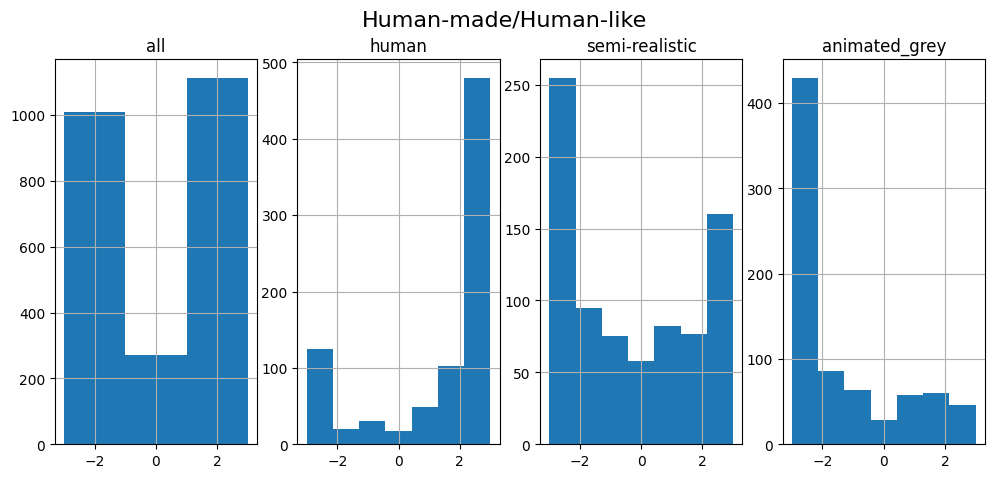

All: -0.12, Human: 1.52, Semi Realistic: -0.39, Cartoon: -1.57, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


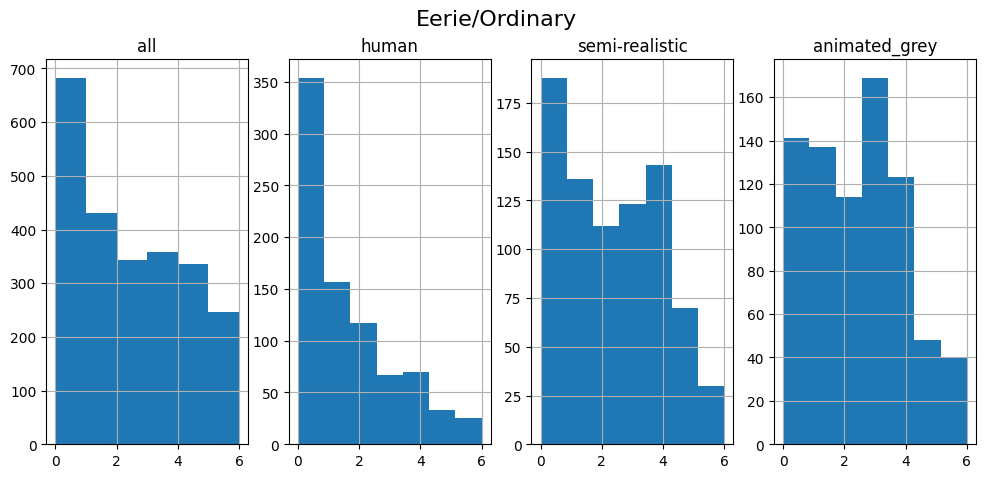

All: 2.03, Human: 1.44, Semi Realistic: 2.28, Cartoon: 2.39, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


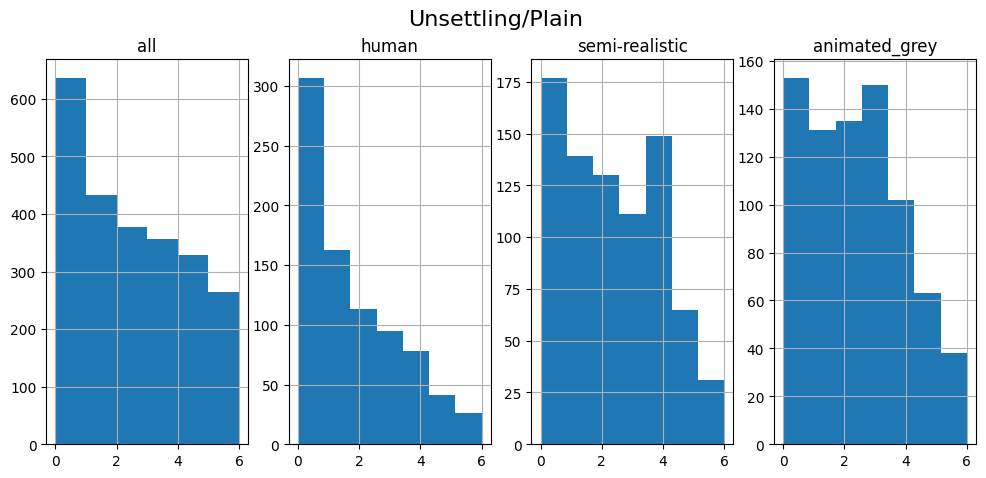

All: 2.08, Human: 1.64, Semi Realistic: 2.29, Cartoon: 2.33, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


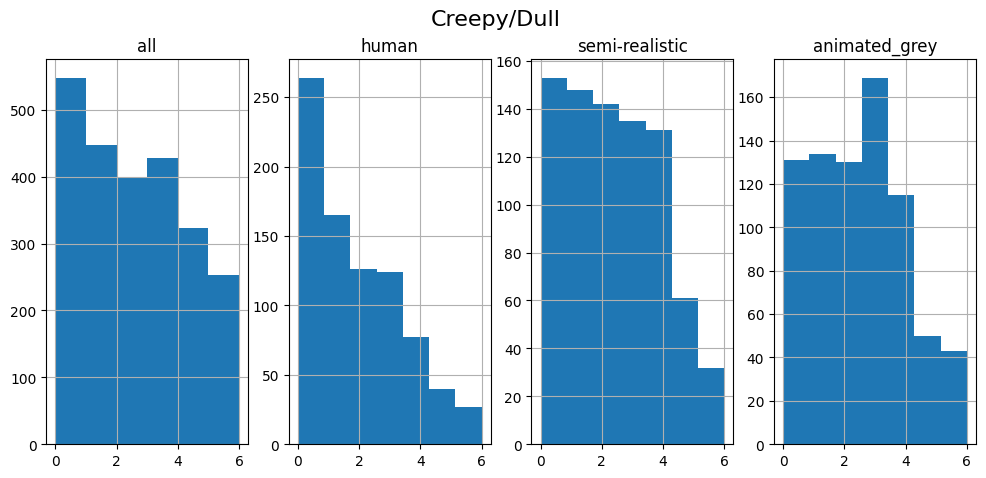

All: 2.16, Human: 1.77, Semi Realistic: 2.32, Cartoon: 2.42, Anova p-value: 0.00, Mann–Whitney p-value: 0.02 (semi vs all)


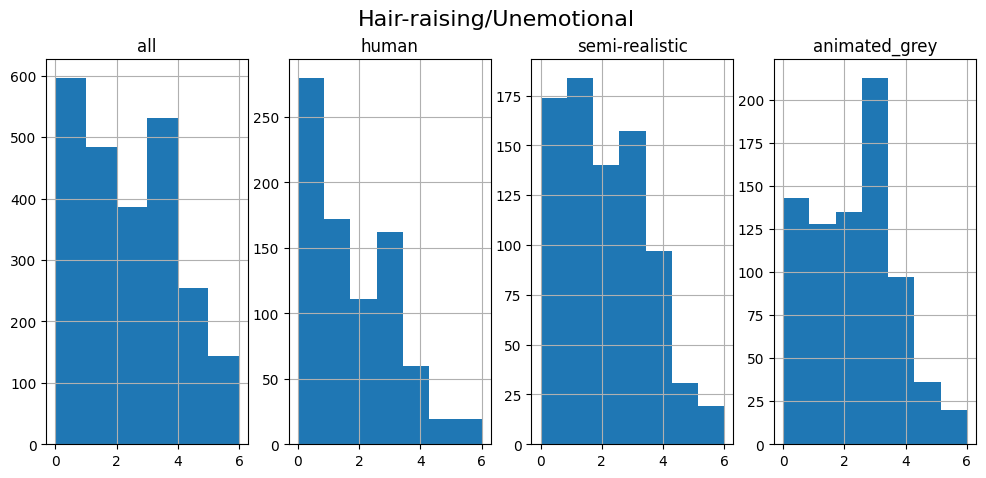

All: 1.94, Human: 1.61, Semi Realistic: 1.99, Cartoon: 2.23, Anova p-value: 0.00, Mann–Whitney p-value: 0.42 (semi vs all)


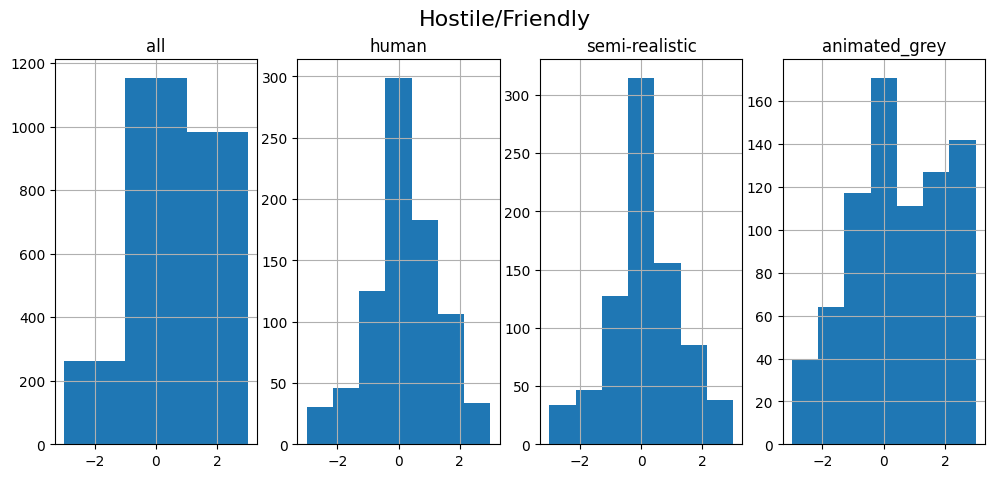

All: 0.31, Human: 0.23, Semi Realistic: 0.15, Cartoon: 0.55, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


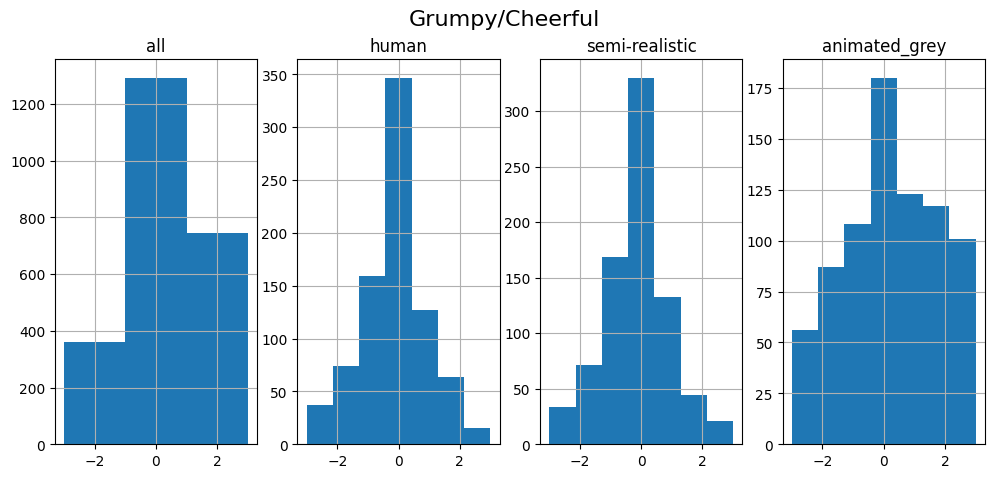

All: -0.02, Human: -0.14, Semi Realistic: -0.16, Cartoon: 0.27, Anova p-value: 0.00, Mann–Whitney p-value: 0.02 (semi vs all)


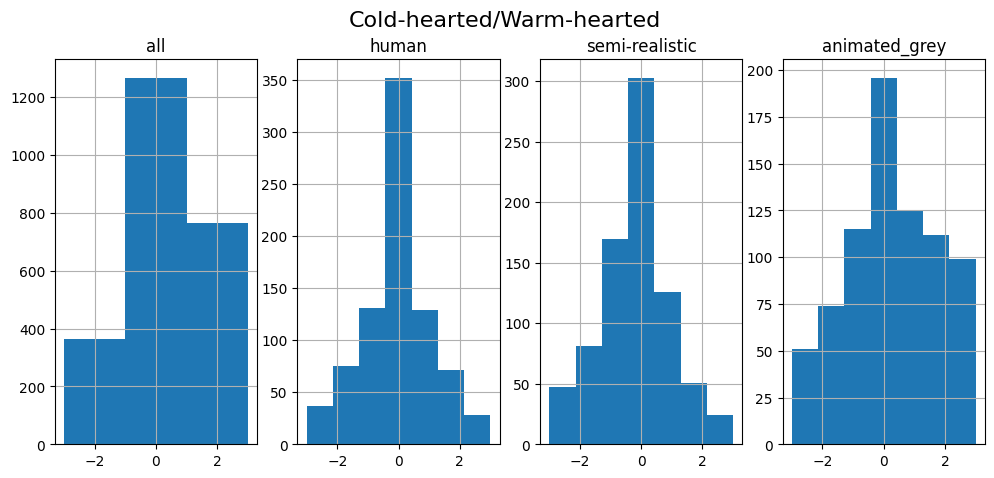

All: 0.01, Human: -0.04, Semi Realistic: -0.22, Cartoon: 0.30, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [106]:
for column in questions:
    analyse_columns(column, ratings)

# Exploratory Factor Analysis

In [107]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

items = ratings[questions]
chi_square_value, p_value = calculate_bartlett_sphericity(items)
print("Bartlett ’s test:")
print(chi_square_value, p_value)
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(items)
print("KMO:")
print(kmo_model)
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(items)
print("Loadings:")
print(fa.loadings_)

Bartlett ’s test:
16377.17742503314 0.0
KMO:
0.8103749399029792
Loadings:
[[-0.20261361 -0.07900425  0.88705216]
 [-0.13778679 -0.05485402  0.86609115]
 [ 0.80126538 -0.19336625 -0.24243107]
 [ 0.88830184 -0.23647593 -0.13785867]
 [ 0.87518713 -0.24542834 -0.09445765]
 [ 0.74039463 -0.16507201 -0.09938627]
 [-0.31275812  0.85188655 -0.0539227 ]
 [-0.14446498  0.8447641  -0.06121436]
 [-0.22943437  0.85643844 -0.04320117]]


# Factors distributions

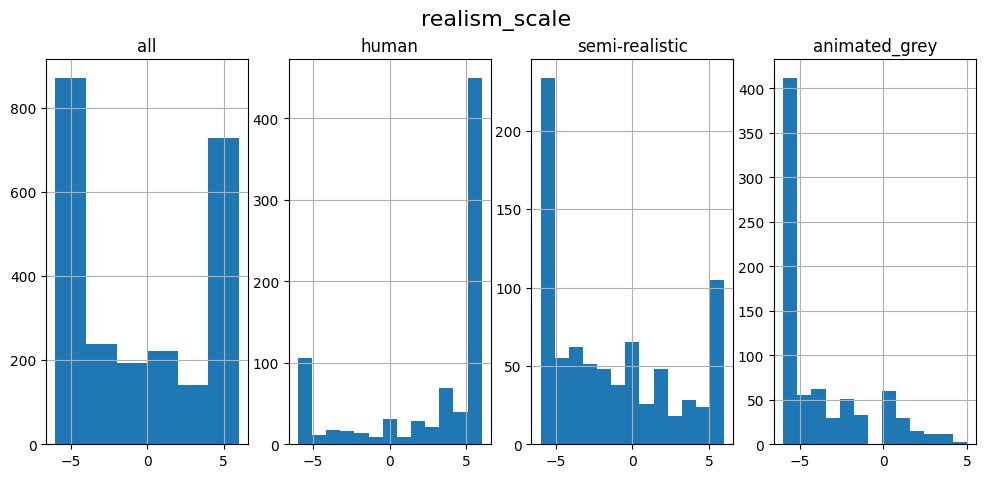

All: -0.74, Human: 2.99, Semi Realistic: -1.47, Cartoon: -3.97, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


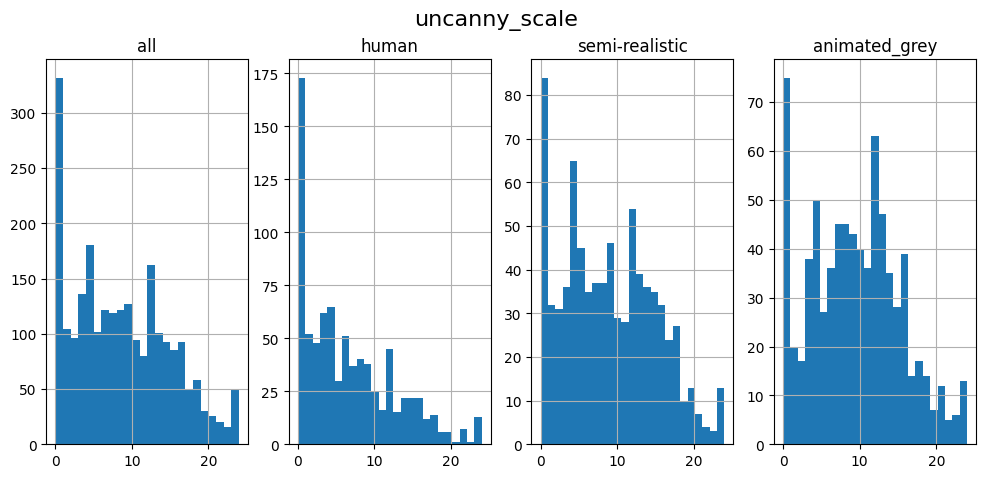

All: 8.21, Human: 6.47, Semi Realistic: 8.88, Cartoon: 9.38, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


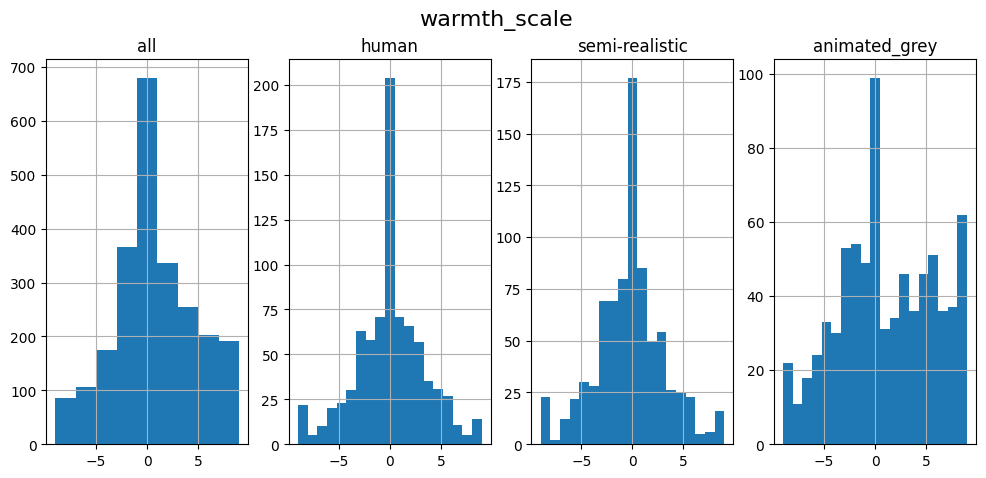

All: 0.30, Human: 0.04, Semi Realistic: -0.23, Cartoon: 1.12, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [108]:
ratings["realism_scale"] = ratings["Fictional/Real"] + ratings["Human-made/Human-like"]
ratings["uncanny_scale"] = ratings["Eerie/Ordinary"] + ratings["Unsettling/Plain"] + ratings[
    "Creepy/Dull"] + ratings["Hair-raising/Unemotional"]
ratings["warmth_scale"] = ratings["Hostile/Friendly"] + ratings["Grumpy/Cheerful"] + ratings[
    "Cold-hearted/Warm-hearted"]

for column in ["realism_scale", "uncanny_scale", "warmth_scale"]:
    analyse_columns(column, ratings)

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_12611/4286937560.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()


Text(0, 0.5, 'uncanny_scale')

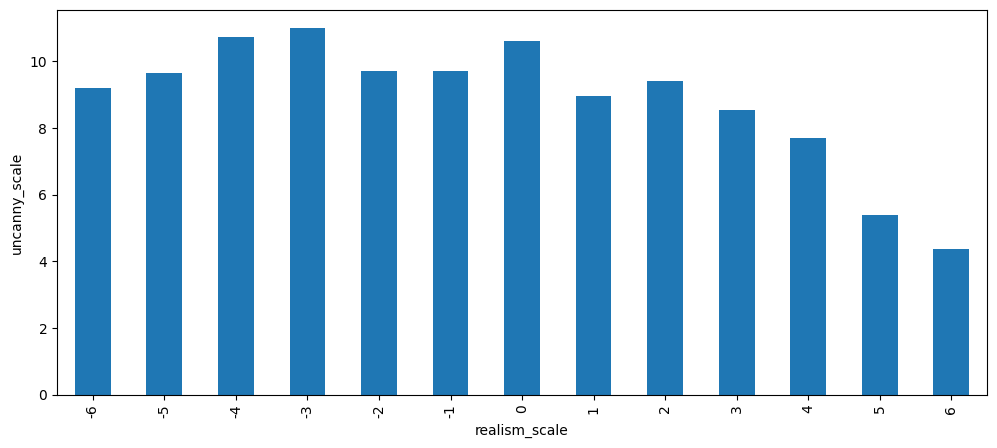

In [109]:
ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()
plt.ylabel("uncanny_scale")

# Best Images for the EEG Experiment

In [110]:
cohort_size = 20
best_images = pd.concat([
ratings[ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size],
ratings[ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=False).reset_index()["img"][:cohort_size],
ratings[ratings["type"] == "animated_grey"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size]
    ]).to_list()
top_ratings = ratings[ratings["img"].isin(best_images)]

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_12611/3414260181.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings[ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size],
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_12611/3414260181.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings[ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=False).reset_index()["img"][:cohort_size],
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_12611

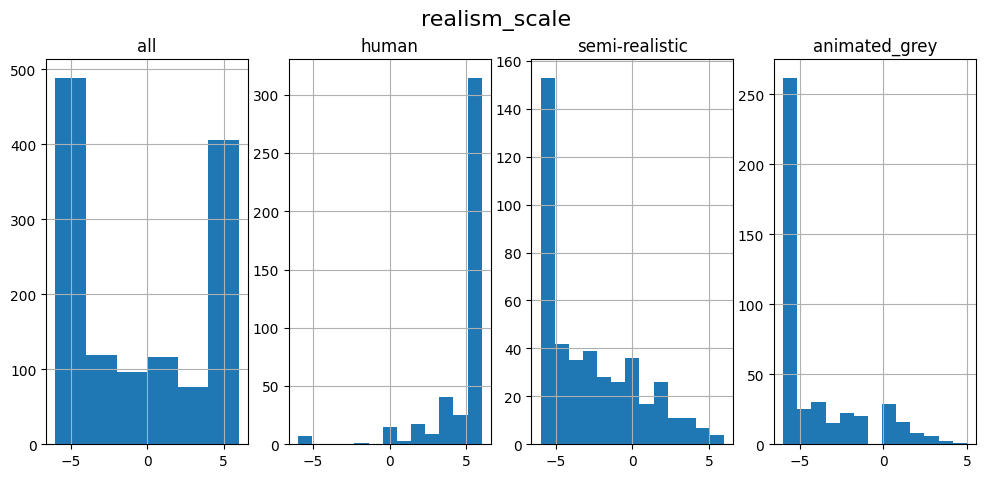

All: -0.71, Human: 5.08, Semi Realistic: -2.90, Cartoon: -4.27, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


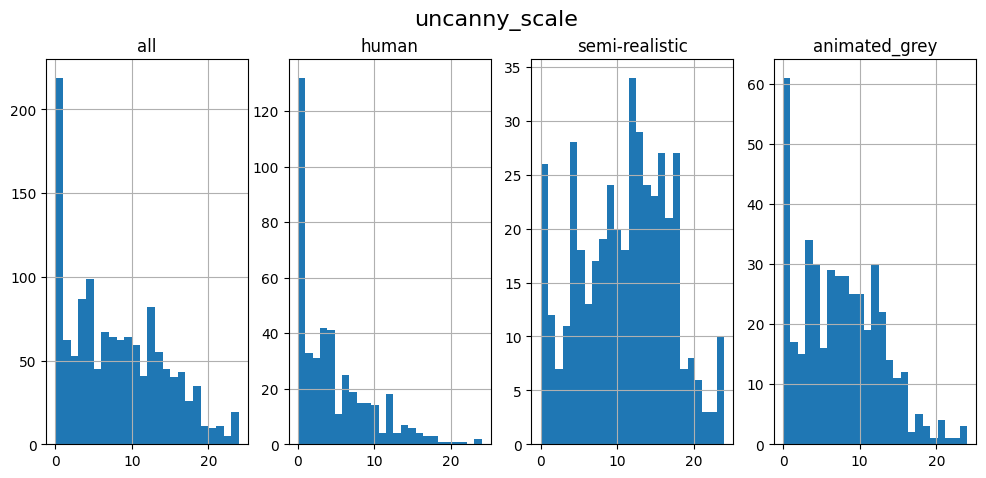

All: 7.60, Human: 4.43, Semi Realistic: 10.94, Cartoon: 7.40, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


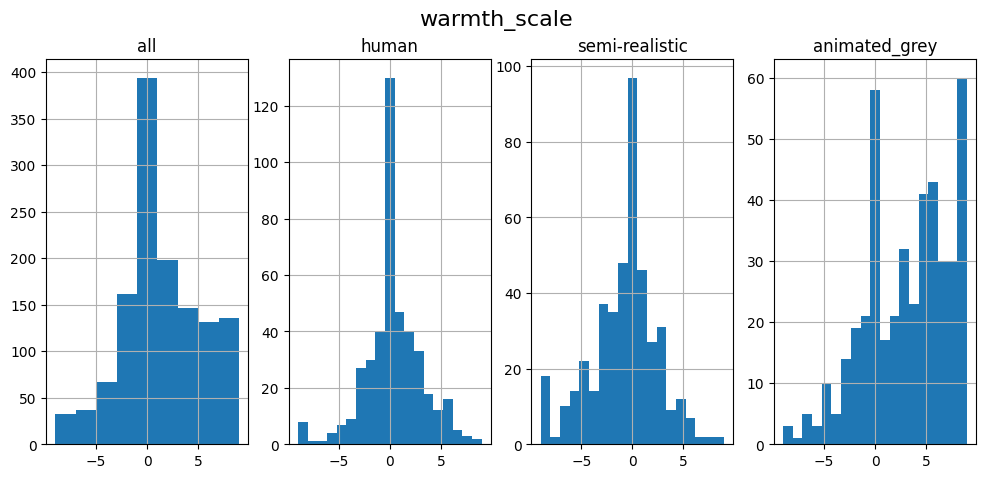

All: 0.97, Human: 0.39, Semi Realistic: -0.80, Cartoon: 3.31, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [111]:
for column in ["realism_scale", "uncanny_scale", "warmth_scale"]:
    analyse_columns(column, top_ratings)

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_12611/3368236120.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()


Text(0, 0.5, 'uncanny_scale')

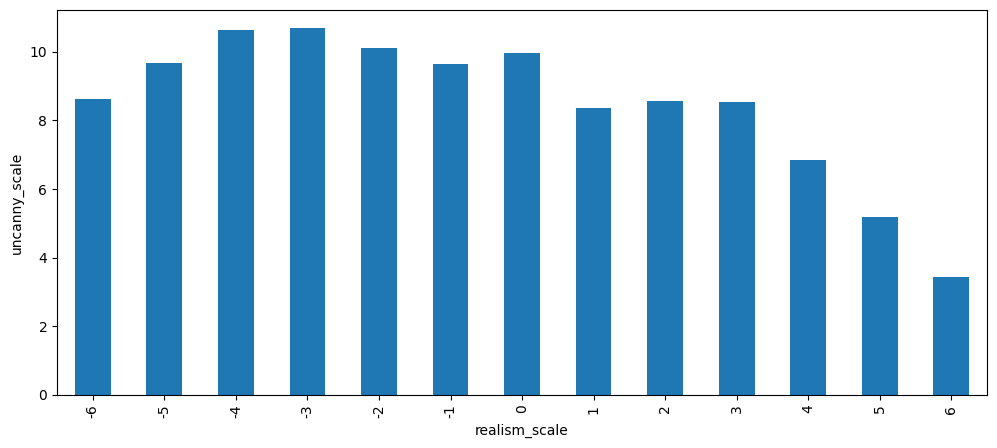

In [112]:
top_ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()
plt.ylabel("uncanny_scale")